## Loading up packages

In [1]:
# Let the program know where to find your tools file.
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# Load up the necessary packages 
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
from scipy.stats import kstwo
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr
from tqdm import tqdm
from multiprocess import Pool
import copy

In [3]:
# Define the path to our data files and the path we want to save our outputs in. 
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/ecol/'
counts_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts_codon_resolution/ecol/'
elon_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/elongation_rates/ecol/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/ecol/'
mutation = 'efp'
samp_num = '2'

# figure out if the notebook has already been done for this dataset and only run the
# visualizations. 
if os.path.isfile(save_path + "ks_table_" + samp_num + ".csv") == True:
    pre_load = True
else:
    pre_load = False

In [5]:
def load_count_positions_v2(csv_name, counts_path):
    data = []
    gene_names = []
    with open(counts_path + csv_name, newline = '') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            data.append(row)
    blank=data.pop(0)
            
    for i,ii in zip(data, range(len(data))):
        for j,jj in zip(i, range(len(i))):
            try:
                x = int(float(j))
                data[ii][jj] = x
            except:
                pass
            
    # Remove empty space
    for i,ii in zip(data, range(len(data))):
        x = list(filter(('').__ne__, i))
        data[ii] = x
        
    # Convert lists to np.arrays
    for i,ii in zip(data, range(len(data))):
        gene_names.append(data[ii][1])
        data[ii] = np.array(data[ii][2:])
    
    return data, gene_names

## Loading up the csv file.

In [6]:
# Load in the count positions data.
data_mutant, names_mutant = load_count_positions_v2(mutation+"_"+samp_num+"_counts.csv",counts_path)
data_control, names_control = load_count_positions_v2("control_"+ samp_num +"_counts.csv",counts_path)

In [7]:
# Load in the elongation rates data.
elon_mutant = kat.load_elongation_rates(mutation + '_' + samp_num + '_elongation_rates', elon_path)
elon_control = kat.load_elongation_rates('control' + '_' + samp_num + '_elongation_rates', elon_path)

## Define functions

In [8]:
# Calculate the smoothed density vector pbar for xth entry with length n-9
def get_pbar_from_count(transcript):
    transcript = transcript + 1 #All elongation rates were calculated this way to set a new baseline
    M = sum(transcript)
    p = transcript/M
    x=0
    pbar=[]
    for px in p:
        pbar_x = 0.1*sum(p[x:x+10]) #it is x+10 not x+9 because python does not include the final index.
        pbar.append(pbar_x)
        x = x+1
        if x  == len(p)-9:
            break
    pbar = np.array(pbar)
    return(pbar)

## Calculate Smoothed Vector Arrays

In [9]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
mutant_list = []
control_list = []
gene_list = []
for tr_m, tr_c, gene_name in zip(data_mutant, data_control, names_mutant):
    if len(tr_m) > 100 and sum(tr_m)/len(tr_m) > 0.5 and sum(tr_c)/len(tr_c) > 0.5:
        mutant_list.append(tr_m)
        control_list.append(tr_c)
        gene_list.append(gene_name)

In [10]:
max_pool = 20

# get smoothed vector arrays for all of the control data.
if pre_load == False:
    with Pool(max_pool) as p:
        pool_control = list(
            tqdm(
                p.imap(kat.get_smoothed_vector_parallel,
                       control_list),
                total=len(control_list)
            )
        )    
# Why do some of these (12430) take so much longer than others? 

100%|██████████████████████████████████████████████████████████████████████████████████| 2328/2328 [00:03<00:00, 621.67it/s]


In [11]:
# get smoothed vector arrays for all of the mutant data.
if pre_load == False:
    with Pool(max_pool) as p:
        pool_mutant = list(
            tqdm(
                p.imap(kat.get_smoothed_vector_parallel,
                       mutant_list),
                total=len(mutant_list)
            )
        )    

100%|██████████████████████████████████████████████████████████████████████████████████| 2328/2328 [00:03<00:00, 622.35it/s]


## Determine KS statistic for all transcripts

In [12]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == False:
    ks_list = []
    len_list = []
    for tr_m, tr_c, index in zip(mutant_list, control_list, list(range(len(mutant_list)))):
        position = np.array(list(range(len(tr_m))))
        smoothed_vec_m, cumul_m = pool_mutant[index]
        smoothed_vec_c, cumul_c = pool_control[index]
        ks = max(abs(cumul_m - cumul_c))
        ks_list.append(ks)
        len_list.append(len(tr_m))
            
    # reorganizing the lists into a dataframe. 
    df_b = pd.DataFrame(list(zip(gene_list, ks_list, len_list)))
    df_b.columns = ["gene_ID", "ks_stat", "gene_length"]
    df_b.to_csv(save_path + "ks_table_" + samp_num + ".csv", index=False)

In [13]:
# An optional line that loads up a pre-made dataset
if pre_load == True:
    df_b = pd.read_csv(save_path + "ks_table_" + samp_num + ".csv")

(0.0, 0.7)

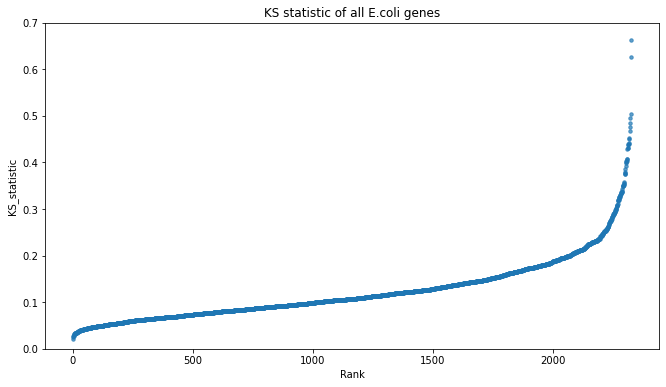

In [14]:
# Plot the KS values for each gene from lowest to highest. 
figure(figsize = (11,6))
plt.scatter(list(range(len(df_b["ks_stat"]))), sorted(df_b["ks_stat"]), s=12, alpha = 0.7)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all E.coli genes")
plt.ylim(0,0.7)

#### Alright, now how do I bin these by gene length? Quick thought, would I be able to filter out those ones I really don't like by just saying that if the maximum value is nearly equal to the sum of the entire transcript then do not count it? maybe it would not be good to cut all of that out. 

In [15]:
# Create a column in the data frame containing the size group for each gene.
size_groups = []
for i in df_b["gene_length"]:
    if i < 220:
        size_groups.append(1)
    elif i >= 220 and i < 600:
        size_groups.append(2)
    elif i >= 600:
        size_groups.append(3)
df_b["size_groups"] = size_groups

In [16]:
# Find all of the transcripts with a KS stat above a certain threshold and group them by gene ID
group = df_b[(df_b['ks_stat'] > 0.4) & (df_b['size_groups'] == 3)].groupby('gene_ID')

# Create a list of all of the unique genes 
diff_dist = group.apply(lambda x: x['ks_stat'].unique())

In [17]:
len(diff_dist)

3

In [18]:
df_b

,gene_ID,ks_stat,gene_length,size_groups
0,thrA,0.096774,821,3
1,thrB,0.035753,311,2
2,thrC,0.085948,429,2
3,yaaA,0.091079,259,2
4,talB,0.085957,318,2
...,...,...,...,...
2323,rob,0.213277,290,2
2324,creA,0.124142,158,1
2325,creB,0.156610,230,2
2326,arcA,0.073659,239,2


In [19]:
def big_dif(diff_dist, gene_names, data_mutant, data_control, figsize = (16,50), fontsize = 12, stat_name = "ks_stat ="):
    '''
    A function which creates a large graph showing the profile arrays for a list of transcripts
    
    returns a matplotlib axis object. 
    '''
    fig,ax = plt.subplots(len(diff_dist), 2, figsize = figsize)
    for axi, stat, gi in zip(ax, diff_dist, diff_dist.index):
        for tr_m, tr_c, name in zip(data_mutant, data_control, gene_names):
            if gi == name:
                my_vec_mutant = tr_m
                my_vec_control = tr_c
                maxi = max([max(my_vec_mutant), max(my_vec_control)])*1.1

                axi[0].plot(my_vec_mutant)
                axi[0].text(len(my_vec_mutant)/2, maxi/1.2, stat_name + str(stat), fontsize = fontsize)
                axi[0].set_ylim([0,maxi])
                axi[0].set_ylabel("Read Counts", fontsize = fontsize)
                axi[0].set_xlabel("Codon Position", fontsize = fontsize)
                axi[0].set_title("mutant " + gi, fontsize = fontsize)
                axi[1].plot(my_vec_control)
                axi[1].set_ylim([0,maxi])
                axi[1].set_ylabel("Read Counts", fontsize = fontsize)
                axi[1].set_xlabel("Codon Position", fontsize = fontsize)
                axi[1].set_title("control " + gi, fontsize = fontsize)
    fig.tight_layout()
            
    return ax

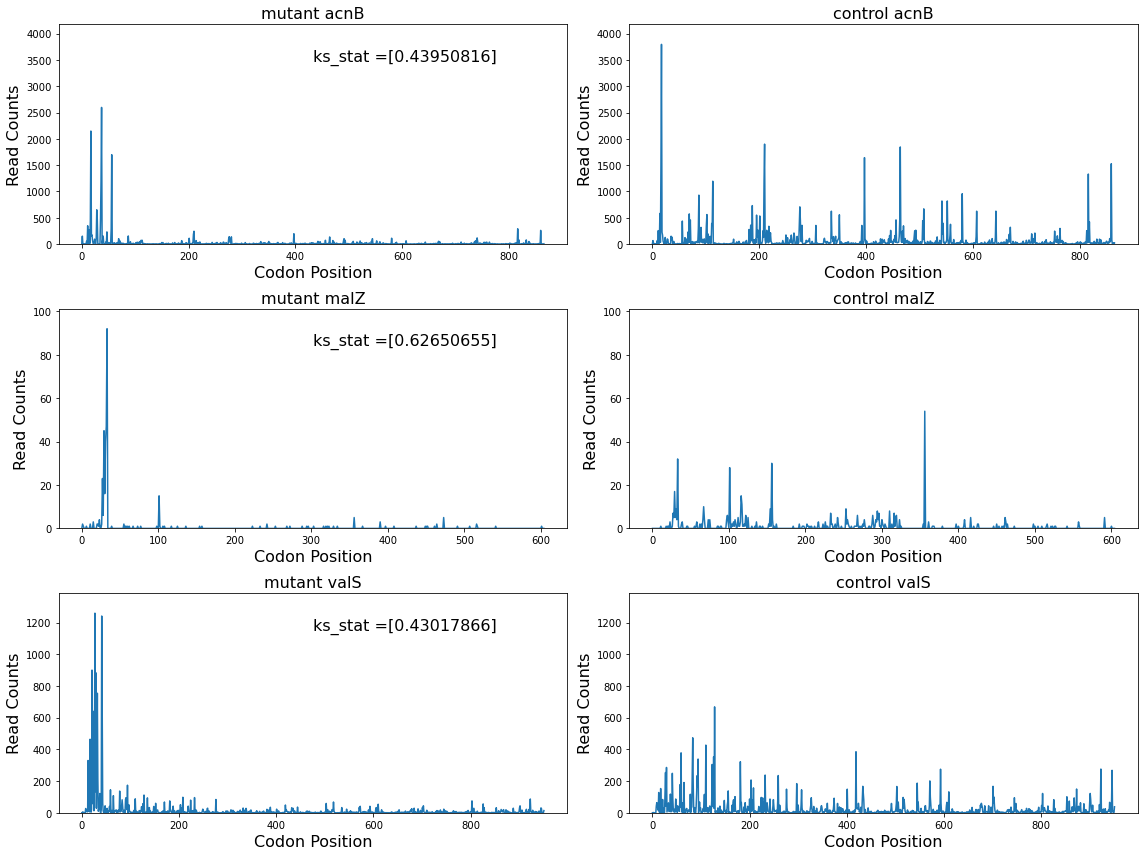

In [20]:
# Look at the smoothed count distributions for each of the transcripts that passed the threshold
ax = big_dif(diff_dist, gene_list, mutant_list, control_list, figsize = (16,len(diff_dist)*4), fontsize = 16)

## Determining the correlation between the KS statistic and the Mass spectrometry data.

In [21]:
# Loading in the table containing the mass spec data
wool_table = pd.read_csv('/home/keeganfl/Desktop/Work_Fall_2021/data_tables/Woolstenhulme_table.csv')

In [22]:
# merging mass spec data with our data. 
ms_compare = pd.merge(wool_table, df_b, how='inner', left_on='Gene', right_on='gene_ID')

In [23]:
# Cleaning up the data
ms_compare = ms_compare[ms_compare['MS_WT/EFP'] != "nd"]
ms_compare = ms_compare.reset_index()

In [24]:
# Converting everything to a float for proper graphing
for ms,i in zip(ms_compare["MS_WT/EFP"], list(range(len(ms_compare["MS_WT/EFP"])))):
    ms_compare.loc[i, "MS_WT/EFP"] = float(ms)

In [25]:
ms_compare["MS_WT/EFP"].astype(float)

0     1.81
1     1.46
2     4.11
3     5.36
4     0.68
      ... 
68    0.88
69    1.94
70    1.98
71    5.68
72    1.37
Name: MS_WT/EFP, Length: 73, dtype: float64

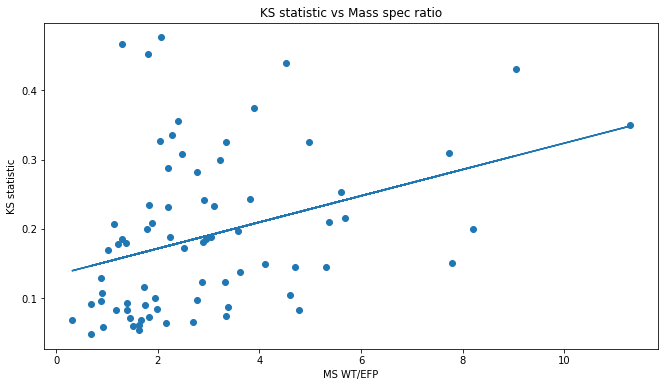

In [26]:
# Creating a simple scatter plot to view the correlation. 
figure(figsize = (11,6))
plt.scatter(ms_compare["MS_WT/EFP"], ms_compare["ks_stat"])
plt.xlabel("MS WT/EFP")
plt.ylabel("KS statistic")
plt.title("KS statistic vs Mass spec ratio")
# Creating a line of best fit. 
m,b = np.polyfit(ms_compare["MS_WT/EFP"].astype(float), ms_compare["ks_stat"],1)
plt.plot(ms_compare["MS_WT/EFP"], m*ms_compare["MS_WT/EFP"] + b)

In [27]:
# Calculating the Pearson Correlation. 
stats.pearsonr(ms_compare["MS_WT/EFP"], ms_compare["ks_stat"])

(0.3486997755198077, 0.002499715654846406)